In [1]:
!pip install numpy pandas jovian opendatasets scikit-learn xgboost --quiet


     |████████████████████████████████| 68 kB 1.9 MB/s 


In [3]:
import opendatasets as od

In [4]:
dataset_url = 'https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/overview'


In [5]:
%%time
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: guocong5340
Your Kaggle Key: ··········


100%|██████████| 1.56G/1.56G [00:11<00:00, 146MB/s]



Extracting archive ./new-york-city-taxi-fare-prediction/new-york-city-taxi-fare-prediction.zip to ./new-york-city-taxi-fare-prediction
CPU times: user 45.8 s, sys: 13.2 s, total: 59 s
Wall time: 2min 29s


In [6]:
data_dir = './new-york-city-taxi-fare-prediction'


In [7]:
import pandas as pd
import random

In [8]:
!head {data_dir}/train.csv

key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.84161,40.712278,1
2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.76127,-73.991242,40.750562,2
2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.98713,40.733143,-73.991567,40.758092,1
2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1
2011-01-06 09:50:45.0000002,12.1,2011-01-06 09:50:45 UTC,-74.000964,40.73163,-73.972892,40.758233,1
2012-11-20 20:35:00.0000001,7.5,2012-11-20 20:35:00 UTC,-73.980002,40.751662,-73.973802,40.764842,1
2012-01-04 17:22:00.00000081,16.5,2012-01-04 17:22:00 UTC,-73.9513,40.774138,-73.990095,40.751048,1
2012-12-03 13:10:00.000000125,9,2012-12-03 13:10:00 UTC,-74.006462,40.726713,-73.99

Data column
*   key
*   fair_amount (target column),
*   pickup_datetime,
*   pickup_longitude,
*   pickup_latitude,
*   dropoff_longitude,
*   dropoff_latitude,
*   passenger_count





## load data

In [9]:
%%time
sample_frac = 0.0002
selected_cols = 'fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count'.split(',')
dtypes = {
    'fare_amount': 'float32',
    'pickup_longitude': 'float32',
    'pickup_latitude': 'float32',
    'dropoff_longitude': 'float32',
    'passenger_count': 'float32'
}

def skip_row(row_idx):
    if row_idx == 0:
        return False
    return random.random() > sample_frac

random.seed(42)
df = pd.read_csv(data_dir+"/train.csv", 
                 usecols=selected_cols, 
                 dtype=dtypes, 
                 parse_dates=['pickup_datetime'], 
                 skiprows=skip_row)

CPU times: user 37.8 s, sys: 1.07 s, total: 38.9 s
Wall time: 51.2 s


In [10]:
df


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,5.7,2010-06-02 13:47:00+00:00,-73.965118,40.796040,-73.979431,40.781878,1.0
1,12.5,2009-12-25 02:10:00+00:00,-73.993279,40.730091,-73.986778,40.771552,3.0
2,4.9,2010-08-24 14:11:00+00:00,0.000000,0.000000,0.000000,0.000000,1.0
3,16.5,2013-06-17 07:32:22+00:00,-73.966316,40.794621,-73.969887,40.750738,1.0
4,10.1,2009-10-18 17:04:00+00:00,-73.999603,40.733475,-73.987015,40.767592,1.0
...,...,...,...,...,...,...,...
11132,5.3,2012-06-03 00:20:42+00:00,-73.991402,40.765469,-74.004730,40.751998,1.0
11133,16.5,2010-10-05 21:21:38+00:00,-73.989868,40.729565,-73.929832,40.759193,1.0
11134,3.3,2012-08-01 12:28:06+00:00,-73.971855,40.763168,-73.968712,40.767423,1.0
11135,18.5,2010-02-27 00:13:00+00:00,-73.985970,40.727886,-73.967903,40.792995,5.0



## data processing
extract year, month, day, hour from given data


In [11]:
def date(df, col):
    df[col + '-year'] = df[col].dt.year
    df[col + '-month'] = df[col].dt.month
    df[col + '-day'] = df[col].dt.day
    df[col + '-hour'] = df[col].dt.hour
date(df, 'pickup_datetime')
df

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime-year,pickup_datetime-month,pickup_datetime-day,pickup_datetime-hour
0,5.7,2010-06-02 13:47:00+00:00,-73.965118,40.796040,-73.979431,40.781878,1.0,2010,6,2,13
1,12.5,2009-12-25 02:10:00+00:00,-73.993279,40.730091,-73.986778,40.771552,3.0,2009,12,25,2
2,4.9,2010-08-24 14:11:00+00:00,0.000000,0.000000,0.000000,0.000000,1.0,2010,8,24,14
3,16.5,2013-06-17 07:32:22+00:00,-73.966316,40.794621,-73.969887,40.750738,1.0,2013,6,17,7
4,10.1,2009-10-18 17:04:00+00:00,-73.999603,40.733475,-73.987015,40.767592,1.0,2009,10,18,17
...,...,...,...,...,...,...,...,...,...,...,...
11132,5.3,2012-06-03 00:20:42+00:00,-73.991402,40.765469,-74.004730,40.751998,1.0,2012,6,3,0
11133,16.5,2010-10-05 21:21:38+00:00,-73.989868,40.729565,-73.929832,40.759193,1.0,2010,10,5,21
11134,3.3,2012-08-01 12:28:06+00:00,-73.971855,40.763168,-73.968712,40.767423,1.0,2012,8,1,12
11135,18.5,2010-02-27 00:13:00+00:00,-73.985970,40.727886,-73.967903,40.792995,5.0,2010,2,27,0


calculate distance from given longitude and latitude

In [12]:
#reference:
#https://stackoverflow.com/questions/29545704/fast-haversine-approximation-python-pandas

import numpy as np
from math import radians, cos, sin, asin, sqrt

def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

def distance(df):
    df['distance'] = haversine_np(df['pickup_longitude'], df['pickup_latitude'], df['dropoff_longitude'], df['dropoff_latitude'])

distance(df)
df

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime-year,pickup_datetime-month,pickup_datetime-day,pickup_datetime-hour,distance
0,5.7,2010-06-02 13:47:00+00:00,-73.965118,40.796040,-73.979431,40.781878,1.0,2010,6,2,13,1.981816
1,12.5,2009-12-25 02:10:00+00:00,-73.993279,40.730091,-73.986778,40.771552,3.0,2009,12,25,2,4.639648
2,4.9,2010-08-24 14:11:00+00:00,0.000000,0.000000,0.000000,0.000000,1.0,2010,8,24,14,0.000000
3,16.5,2013-06-17 07:32:22+00:00,-73.966316,40.794621,-73.969887,40.750738,1.0,2013,6,17,7,4.885573
4,10.1,2009-10-18 17:04:00+00:00,-73.999603,40.733475,-73.987015,40.767592,1.0,2009,10,18,17,3.936489
...,...,...,...,...,...,...,...,...,...,...,...,...
11132,5.3,2012-06-03 00:20:42+00:00,-73.991402,40.765469,-74.004730,40.751998,1.0,2012,6,3,0,1.870865
11133,16.5,2010-10-05 21:21:38+00:00,-73.989868,40.729565,-73.929832,40.759193,1.0,2010,10,5,21,6.032333
11134,3.3,2012-08-01 12:28:06+00:00,-73.971855,40.763168,-73.968712,40.767423,1.0,2012,8,1,12,0.542174
11135,18.5,2010-02-27 00:13:00+00:00,-73.985970,40.727886,-73.967903,40.792995,5.0,2010,2,27,0,7.393392


## seperate df into training set and validation set

In [13]:
from sklearn.model_selection import train_test_split



**TRAINING DATA**




In [14]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)


In [15]:
len(train_df), len(val_df)


(8909, 2228)

In [16]:
#remove sample data with missing values
train_df = train_df.dropna()
val_df = val_df.dropna()

In [17]:
len(train_df), len(val_df)

(8909, 2228)

In [18]:
df.columns

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
       'pickup_datetime-year', 'pickup_datetime-month', 'pickup_datetime-day',
       'pickup_datetime-hour', 'distance'],
      dtype='object')

In [19]:
input_cols = ['pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
       'pickup_datetime-year', 'pickup_datetime-month', 'pickup_datetime-day', 'pickup_datetime-hour', 'distance',]
target_col = 'fare_amount'


In [20]:
train_inputs = train_df[input_cols]
train_targets = train_df[target_col]


In [21]:
train_inputs


,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime-year,pickup_datetime-month,pickup_datetime-day,pickup_datetime-hour,distance
5967,-73.968666,40.791473,-73.970329,40.799167,5.0,2011,3,2,13,0.866177
10615,-73.966949,40.763966,-73.967087,40.768969,1.0,2012,1,6,18,0.556107
6615,-73.970901,40.748089,-73.958557,40.784031,1.0,2015,4,5,9,4.126923
8459,-73.982933,40.756550,-73.963066,40.758380,2.0,2014,2,4,12,1.684818
4881,-73.998924,40.713676,-73.990837,40.750352,1.0,2009,10,10,14,4.132227
...,...,...,...,...,...,...,...,...,...,...
5734,-74.001572,40.735870,-73.963860,40.770932,1.0,2013,6,8,11,5.025721
5191,-73.969437,40.785404,-73.991615,40.738729,1.0,2009,10,17,18,5.512261
5390,-73.946693,40.791672,-73.942589,40.786282,1.0,2013,2,8,8,0.691442
860,-73.981422,40.746609,-73.978653,40.782975,3.0,2010,9,15,9,4.048119


In [22]:
train_targets


5967      4.1
10615     3.7
6615     12.5
8459     10.0
4881     13.7
         ... 
5734     16.5
5191     14.5
5390      4.5
860       9.7
7270      6.5
Name: fare_amount, Length: 8909, dtype: float32

validation data

In [27]:
val_inputs = val_df[input_cols]
val_targets = val_df[target_col]


## linear regression 

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


In [24]:
linreg_model = LinearRegression()
linreg_model.fit(train_inputs, train_targets)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [28]:
train_pred = linreg_model.predict(train_inputs)

In [30]:
error = mean_squared_error(train_targets, train_preds, squared=False)
print("mean squared error for training_inputs is", error)

mean squared error for training_inputs is 10.154319565279675


In [33]:
val_pred= linreg_model.predict(val_inputs)
error = mean_squared_error(val_targets, val_pred, squared=False)
print("mean squared error for training_inputs is", error)

mean squared error for training_inputs is 10.129437888541114


## Lasso regression

In [49]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

In [53]:
lasso_reg = linear_model.Lasso(alpha=0.1)
lasso_reg .fit(train_inputs, train_targets)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [58]:
train_pred =lasso_reg.predict(train_inputs)
error = mean_squared_error(train_targets, train_pred, squared=False)

print("mean squared error for training_inputs is", error)

mean squared error for training_inputs is 10.155019996069129


In [59]:
val_pred= lasso_reg.predict(val_inputs)
error = mean_squared_error(val_targets, val_pred, squared=False)
print("mean squared error for training_inputs is", error)

mean squared error for training_inputs is 10.128457174371336


## random forest

In [34]:
from sklearn.ensemble import RandomForestRegressor

In [36]:
%%time
random_forest_model = RandomForestRegressor(max_depth=10, n_jobs=-1, random_state=42, n_estimators=50)
random_forest_model.fit(train_inputs, train_targets)

CPU times: user 2.71 s, sys: 8.16 ms, total: 2.72 s
Wall time: 1.54 s


In [39]:
train_pred = random_forest_model.predict(train_inputs)
error = mean_squared_error(train_targets, train_pred, squared=False)

print("mean squared error for training_inputs is", error)

mean squared error for training_inputs is 2.8336018131606173


In [40]:
val_pred= linreg_model.predict(val_inputs)
error = mean_squared_error(val_targets, val_pred, squared=False)
print("mean squared error for training_inputs is", error)

mean squared error for training_inputs is 10.129437888541114


## Gradient Boosting with tuning parameter

In [60]:
from xgboost import XGBRegressor

In [61]:
reference: https://jovian.ai/aakashns
import matplotlib.pyplot as plt

def test_params(ModelClass, **params):
    model = ModelClass(**params).fit(train_inputs, train_targets)
    train_rmse = mean_squared_error(model.predict(train_inputs), train_targets, squared=False)
    val_rmse = mean_squared_error(model.predict(val_inputs), val_targets, squared=False)
    return train_rmse, val_rmse

def test_param_and_plot(ModelClass, param_name, param_values, **other_params):
    train_errors, val_errors = [], [] 
    for value in param_values:
        params = dict(other_params)
        params[param_name] = value
        train_rmse, val_rmse = test_params(ModelClass, **params)
        train_errors.append(train_rmse)
        val_errors.append(val_rmse)
    
    plt.figure(figsize=(10,6))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_errors, 'b-o')
    plt.plot(param_values, val_errors, 'r-o')
    plt.xlabel(param_name)
    plt.ylabel('RMSE')
    plt.legend(['Training', 'Validation'])
best_params = {
    'random_state': 42,
    'n_jobs': -1,
    'objective': 'reg:squarederror'
}

CPU times: user 15 s, sys: 32.7 ms, total: 15 s
Wall time: 7.73 s


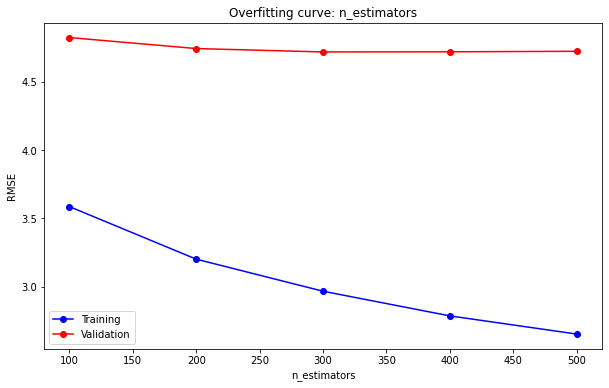

In [65]:
%%time 
test_param_and_plot(XGBRegressor, 'n_estimators', [100,200,300,400,500], **best_params)

CPU times: user 12 s, sys: 28.9 ms, total: 12 s
Wall time: 6.21 s


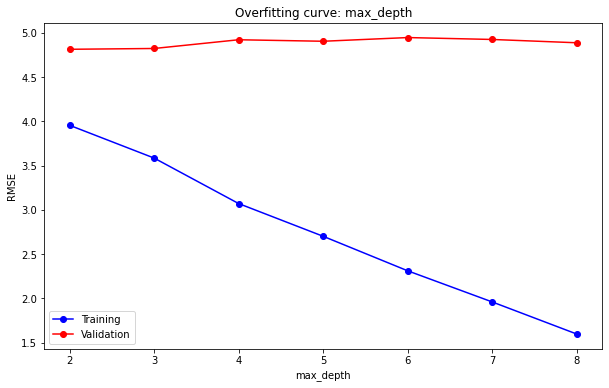

In [71]:
%%time 
test_param_and_plot(XGBRegressor, 'max_depth', [2,3, 4, 5,6,7,8], **best_params)

CPU times: user 8 s, sys: 25.1 ms, total: 8.03 s
Wall time: 4.17 s


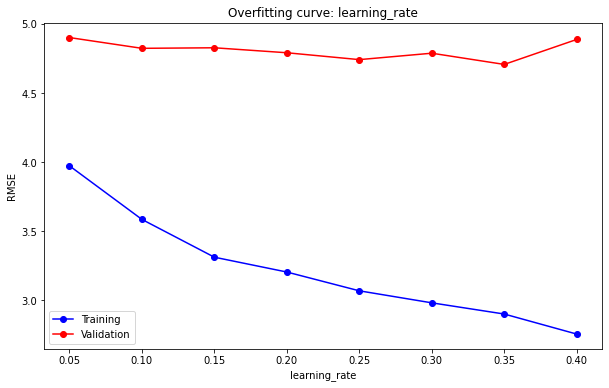

In [70]:
%%time
test_param_and_plot(XGBRegressor, 'learning_rate', [0.05, 0.1,0.15,0.2, 0.25,0.3,0.35,0.4], **best_params)

In [74]:
xgb_model = XGBRegressor(objective='reg:squarederror', n_jobs=-1, random_state=42,
                               n_estimators=500, max_depth=8, learning_rate=0.35)

In [76]:
%%time
xgb_model.fit(train_inputs, train_targets)

CPU times: user 13.1 s, sys: 40.6 ms, total: 13.2 s
Wall time: 6.75 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.35, max_delta_step=0,
             max_depth=8, min_child_weight=1, missing=None, n_estimators=500,
             n_jobs=-1, nthread=None, objective='reg:squarederror',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [77]:
train_pred =xgb_model.predict(train_inputs)
error = mean_squared_error(train_targets, train_pred, squared=False)

print("mean squared error for training_inputs is", error)

mean squared error for training_inputs is 0.02383352


In [78]:
val_pred= xgb_model.predict(val_inputs)
error = mean_squared_error(val_targets, val_pred, squared=False)
print("mean squared error for training_inputs is", error)

mean squared error for training_inputs is 5.0063887
